In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
np.random.seed(0)

# Data import

In [2]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,0,209,236,74,0,0,0,219,79,...,230,151,124,73,59,82,152,0,0,0.000220
1,1,92,150,104,106,0,0,0,192,87,...,88,102,68,87,90,61,127,85,0,0.000068
2,2,0,195,111,113,0,0,0,105,94,...,137,181,126,92,48,171,169,85,0,0.000075
3,3,60,171,76,110,0,0,0,57,94,...,131,183,93,97,83,145,105,85,0,0.000075
4,4,0,184,60,74,0,0,0,45,80,...,73,189,87,78,56,104,152,0,0,0.000068


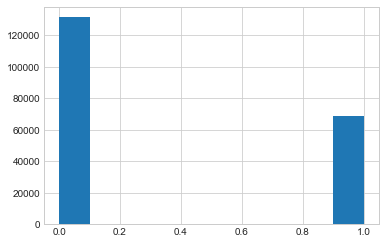

In [3]:
train_df.gen_target.hist()

In [4]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.65733, 0.34267)

In [5]:
size = 224

In [7]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=128, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'pixel_images', folder='train', suffix='.png').normalize(imagenet_stats)

In [8]:
data

ImageDataBunch;

Train: LabelList (160000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /home/giles/Documents/kaggle/higgsml/pixel_images;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,0,0
Path: /home/giles/Documents/kaggle/higgsml/pixel_images;

Test: None

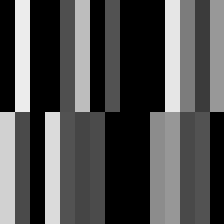

In [9]:
data.train_ds[0][0]

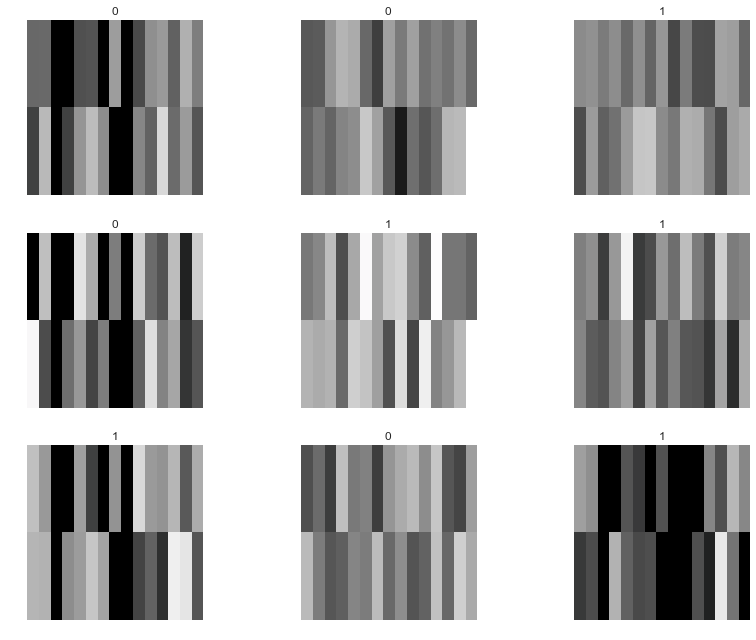

In [10]:
data.show_batch(rows=3, figsize=(12,9))

# Model training

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


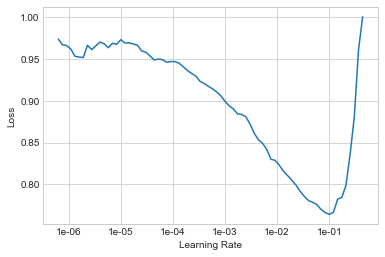

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.405419,0.389101,0.172400,05:10
1,0.388949,0.371080,0.164975,05:12
2,0.381329,0.365065,0.161175,05:10
3,0.362456,0.363455,0.161175,05:12


In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [17]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


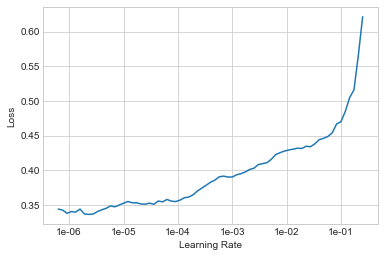

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=slice(1e-7,3e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.357330,0.363050,0.161375,06:45
1,0.358147,0.362896,0.160575,06:48
2,0.354457,0.362482,0.160775,06:53
3,0.365442,0.362265,0.160275,06:48


In [20]:
learn.save('stage-2')

In [21]:
learn.load('stage-2');

In [22]:
learn.export()

## Interpretation

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

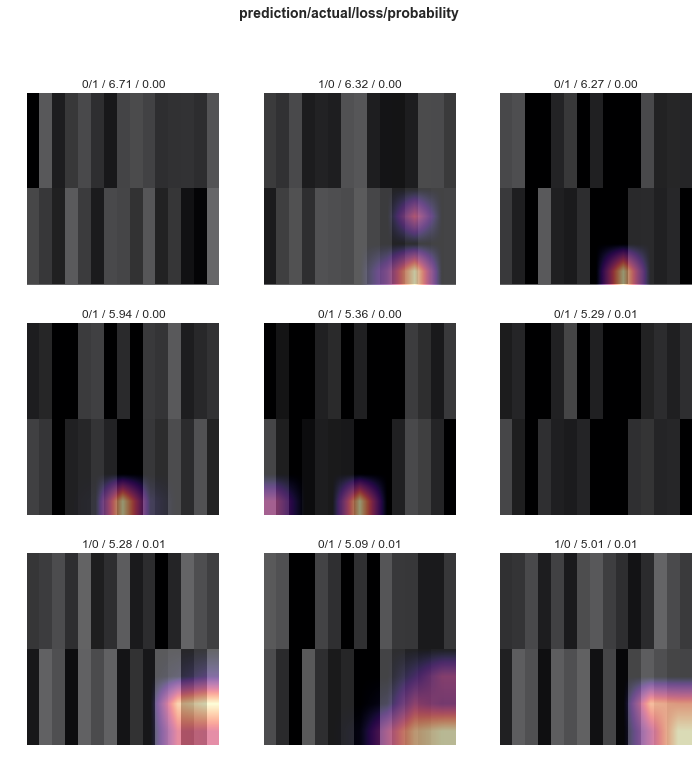

In [24]:
interp.plot_top_losses(9)

### Heatmap
Copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb

In [25]:
x,y = data.valid_ds[1]

In [26]:
m = learn.model.eval();

In [27]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [28]:
from fastai.callbacks.hooks import *

In [29]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [30]:
hook_a,hook_g = hooked_backward()

In [31]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [32]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [33]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,size,size,0),
              interpolation='bilinear', cmap='magma');

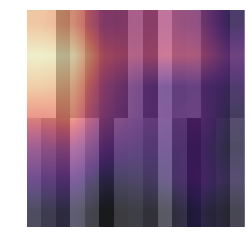

In [34]:
show_heatmap(avg_acts)

### Grad-CAM

In [35]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 7, 7]), torch.Size([512]))

In [36]:
mult = (acts*grad_chan[...,None,None]).mean(0)

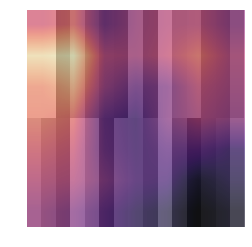

In [37]:
show_heatmap(mult)

# Inference

## Validation

In [38]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,134,91,125,112,0,0,0,174,84,...,146,77,78,209,171,70,136,85,1,0.018636
1,1,101,117,103,114,93,99,157,163,84,...,90,94,91,101,126,194,109,170,1,0.001503
2,2,85,53,89,93,0,0,0,175,135,...,91,108,73,99,140,133,74,85,1,0.001503
3,3,152,74,165,131,0,0,0,138,132,...,87,104,152,73,149,108,89,85,1,0.018636
4,4,224,213,228,182,63,84,142,120,85,...,108,69,244,71,84,198,133,170,0,0.358540


In [39]:
val_lst = ImageList.from_df(val_df, IMG_PATH/'pixel_images', folder='val', suffix='.png')

In [40]:
learn = load_learner(IMG_PATH/'pixel_images', test=val_lst)

In [41]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [42]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


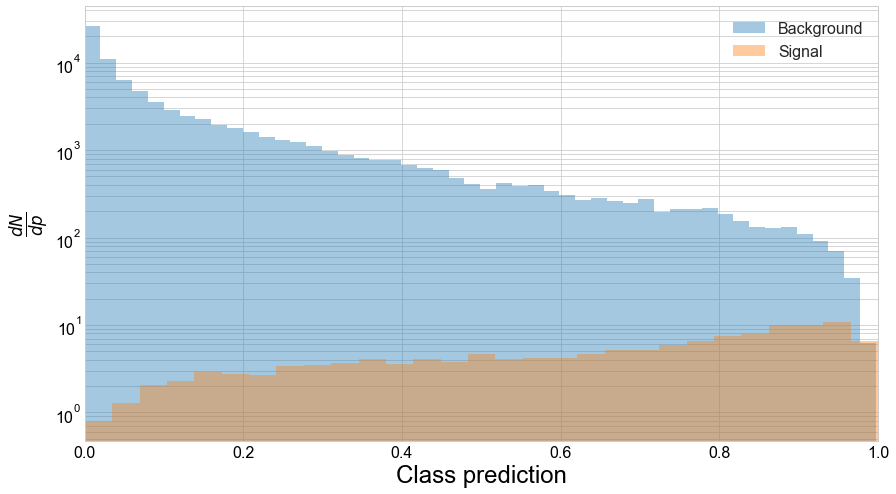

In [43]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.8772656321525574 corresponds to AMS of 3.443862686733552
Maximum AMS for data is 3.616878526158597 at cut of 0.8310664892196655


/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


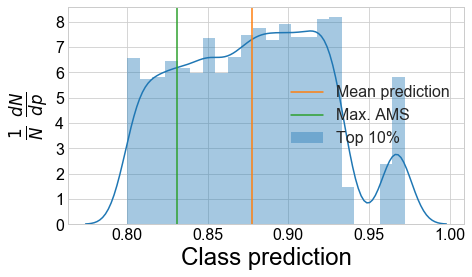

In [44]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.8)

## Test

In [45]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private
0,0,0,179,50,76,0,0,0,34,84,...,178,109,107,64,90,141,0,0,11.246676,0
1,1,0,179,43,89,0,0,0,23,124,...,195,75,137,57,154,150,0,0,2.452419,1
2,2,168,105,172,74,0,0,0,191,80,...,62,60,125,114,129,65,0,1,0.010415,1
3,3,78,146,101,142,0,0,0,63,86,...,222,84,113,104,51,129,85,0,1.117143,1
4,4,111,97,108,157,210,173,52,98,88,...,144,165,79,158,190,122,170,1,0.003789,0


In [46]:
test_lst = ImageList.from_df(test_df, IMG_PATH/'pixel_images', folder='test', suffix='.png')

In [47]:
learn = load_learner(IMG_PATH/'pixel_images', test=test_lst)

In [48]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [49]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [50]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,0,179,50,76,0,0,0,34,84,...,109,107,64,90,141,0,0,11.246676,0,0.008736
1,1,0,179,43,89,0,0,0,23,124,...,75,137,57,154,150,0,0,2.452419,1,0.008135
2,2,168,105,172,74,0,0,0,191,80,...,60,125,114,129,65,0,1,0.010415,1,0.592983
3,3,78,146,101,142,0,0,0,63,86,...,84,113,104,51,129,85,0,1.117143,1,0.025520
4,4,111,97,108,157,210,173,52,98,88,...,165,79,158,190,122,170,1,0.003789,0,0.900541


In [51]:
score_test_df(test_df, cut)

Public:Private AMS: 3.292378617507002 : 3.3247016516410777


(3.292378617507002, 3.3247016516410777)